In [1]:
import os
import re
import warnings
from collections import Counter
from urllib import request

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from konlpy.tag import Okt
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import Constant

In [2]:
# settings
warnings.filterwarnings("ignore")
tf.random.set_seed(123)
plt.style.use("fivethirtyeight")

In [3]:
# data read
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # document column에서 중복되는 글 삭제
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # 행에서  Na값이 있으면 삭제
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    # document column에 있는 문장을 토큰화하여 X_train에 담음
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
            
    # document column에 있는 문장을 토큰화하여 X_test에 담음
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    print(words)
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
len(X_train), len(y_train), len(X_test), len(y_test)

(146182, 146182, 49157, 49157)

In [6]:
# word : index 형태로 되어있는 것을 index : word 형태로 바꿔줌
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

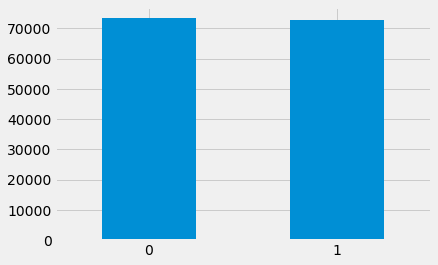

In [8]:
# label 수 확인
train_data['label'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)

리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.981673530256803


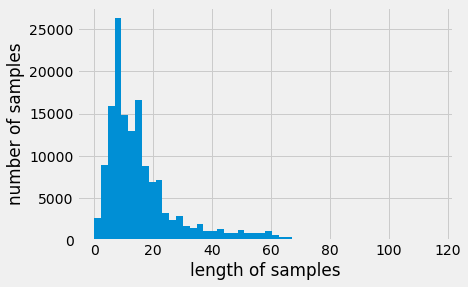

In [9]:
# train 데이터셋 내 문장 길이 분포  
print('리뷰의 최대 길이 :',max(len(i) for i in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

리뷰의 최대 길이 : 105
리뷰의 평균 길이 : 15.932725756250381


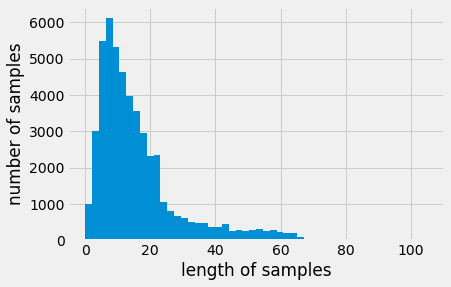

In [18]:
# test 데이터셋 내 문장 길이 분포  
print('리뷰의 최대 길이 :',max(len(i) for i in X_test))
print('리뷰의 평균 길이 :',sum(map(len, X_test))/len(X_test))
plt.hist([len(s) for s in X_test], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [10]:
# 최대 길이 선정
# 90% 이상이 30 미만
maxlen= 30
X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)

In [11]:
vocab_size = len(index_to_word)

In [21]:
#  LSTM으로 학습
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 100),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
# 사용할 Callback 설정
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [23]:
# model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [24]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping, model_checkpoint], 
                   batch_size=32 ,validation_split=0.2
                   )

Epoch 1/100
3654/3655 [============================>.] - ETA: 0s - loss: 0.3719 - acc: 0.8328
Epoch 00001: val_acc improved from -inf to 0.85905, saving model to best_model.h5
3655/3655 [==============================] - 131s 36ms/step - loss: 0.3719 - acc: 0.8328 - val_loss: 0.3248 - val_acc: 0.8590
Epoch 2/100
3655/3655 [==============================] - ETA: 0s - loss: 0.2863 - acc: 0.8782
Epoch 00002: val_acc improved from 0.85905 to 0.86671, saving model to best_model.h5
3655/3655 [==============================] - 131s 36ms/step - loss: 0.2863 - acc: 0.8782 - val_loss: 0.3174 - val_acc: 0.8667
Epoch 3/100
3654/3655 [============================>.] - ETA: 0s - loss: 0.2421 - acc: 0.8999
Epoch 00003: val_acc did not improve from 0.86671
3655/3655 [==============================] - 133s 36ms/step - loss: 0.2421 - acc: 0.8999 - val_loss: 0.3220 - val_acc: 0.8648
Epoch 4/100
3654/3655 [============================>.] - ETA: 0s - loss: 0.2017 - acc: 0.9193
Epoch 00004: val_acc did not 

In [25]:
# history
history_dict = history.history

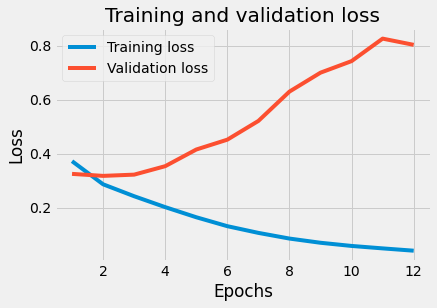

In [27]:
# 빠르게 오버피팅이 되었네...
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs ,loss, label='Training loss')
plt.plot(epochs ,val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 15s 10ms/step - loss: 0.3236 - acc: 0.8606

 테스트 정확도: 0.8606


In [29]:
# 머신러닝으로도 해볼 수 있다는 걸 아십니까!?
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [31]:
# 랜덤포레스트
rf = RandomForestClassifier(random_state=123, n_estimators=350)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
accuracy_score(y_test, rf_pred)

0.6431840836503449

In [32]:
# lightGBM을 사용해볼까
# hyperparameter는 아무거나 한 번 넣어보고
params = {
    'metric': 'acc',
    'learning_rate': 0.05,
    'max_depth': -1,          
    'num_leaves': 500,        
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.7, 
    'bagging_freq': 5,
    'lambda' : 0.8
}

In [33]:
# lightgbm
# 단순히 경험만 해보고 일단 딥러닝으로 돌아갑니다
lgbm = lgb.LGBMClassifier(random_state=123,**params)
lgbm.fit(X_train,y_train)
lgb_pred = lgbm.predict(X_test)
accuracy_score(y_test, lgb_pred)

[LightGBM] [Warning] lambda_l2 is set with lambda=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


0.7116178774131863

In [26]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)
# X_train = get_decoded_sentences(X_train,index_to_word)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = "/home/ssac1/minchae/nodes/exp_04/word2vec.txt"
with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size, 100))
    vectors = model.get_weights()[0]
    for i in range(vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))

In [15]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [16]:
embedding_matrix = np.random.rand(vocab_size, 100)

for i in range(vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

In [17]:
# word2vector
# Activation을 elu를 한 번 써볼까요
model_w = keras.Sequential([
    keras.layers.Embedding(vocab_size, 100,
                          embeddings_initializer=Constant(embedding_matrix),
                          input_length=maxlen,
                          trainable=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(256, activation='elu'),
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_model_2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [18]:
# learning_rate도 한 번 바꿔볼까
model_w.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss='binary_crossentropy', metrics=['acc'])

In [28]:
history = model_w.fit(
    X_train, y_train, epochs=20, callbacks=[early_stopping, model_checkpoint], 
    batch_size=128 ,validation_split=0.3
                   )

Epoch 1/20
800/800 [==============================] - ETA: 0s - loss: 0.2712 - acc: 0.8871
Epoch 00001: val_acc improved from -inf to 0.87418, saving model to best_model.h5
800/800 [==============================] - 12s 15ms/step - loss: 0.2712 - acc: 0.8871 - val_loss: 0.2986 - val_acc: 0.8742
Epoch 2/20
799/800 [============================>.] - ETA: 0s - loss: 0.2138 - acc: 0.9138
Epoch 00002: val_acc did not improve from 0.87418
800/800 [==============================] - 11s 14ms/step - loss: 0.2137 - acc: 0.9138 - val_loss: 0.3162 - val_acc: 0.8740
Epoch 3/20
799/800 [============================>.] - ETA: 0s - loss: 0.1863 - acc: 0.9257
Epoch 00003: val_acc did not improve from 0.87418
800/800 [==============================] - 11s 14ms/step - loss: 0.1863 - acc: 0.9257 - val_loss: 0.3598 - val_acc: 0.8710
Epoch 4/20
796/800 [============================>.] - ETA: 0s - loss: 0.1620 - acc: 0.9364
Epoch 00004: val_acc did not improve from 0.87418
800/800 [==========================

In [ ]:
print("\n 테스트 정확도: %.4f" % (model_w.evaluate(X_test, y_test)[1]))